# Segmentation Experiment

In this notebook different algorithms for segmenting an image are evaluated

In [56]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.misc import imread
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.feature import blob_doh
from skimage.measure import label
import cv2

%matplotlib inline

First we need to load a sample image and also a generated heatmap we want to segment.

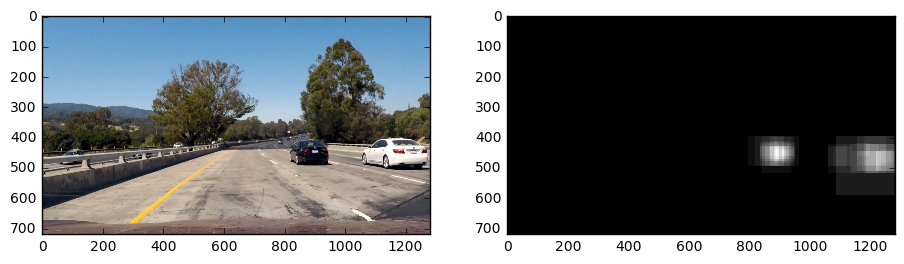

In [57]:
IMG_NUM = 1
img = imread('../test_images/heatmap%s.jpg' % IMG_NUM)[:,:,0]
img_org = imread('../test_images/test%s.jpg' % IMG_NUM)

fig, axis = plt.subplots(1,2, figsize=(11,3))
_ = axis[0].imshow(img_org)
_ = axis[1].imshow(img, cmap='gray')

Then we define two helper functions we will need throughout this notebook

In [58]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

As a first step the heatmap is thresholded to received smoother results. The thresholded heatmap is the input for all segmentation algorithms.

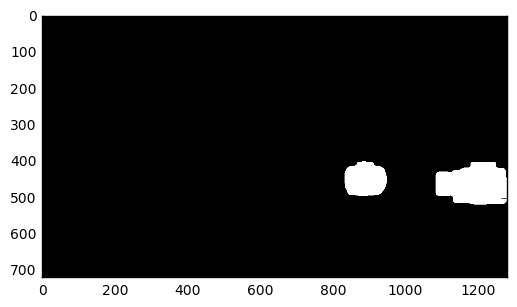

In [59]:
img_thresh = np.zeros(img.shape, dtype=np.uint8)
img_blur = gaussian_blur(img, 21)
img_thresh[img_blur > 50] = 255
_ = plt.imshow(img_thresh, cmap='gray')

# Technique 1: Blob detection 

Finished after 1.118673 seconds


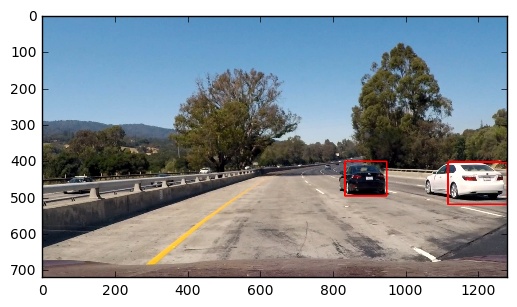

In [60]:
t1 = time.time()
try:
    blobs = blob_doh(img_thresh, num_sigma=4, min_sigma=1, max_sigma=255, threshold=.01)
except IndexError:
    blobs = np.array([])

blobs = blobs[blobs[:, 2] > 16]
boxes = np.zeros((len(blobs), 4), dtype=np.uint32)
for i, blob in enumerate(blobs):
    blob = np.array(blob, dtype=np.int32)
    blob_area = np.array([max(blob[1] - blob[2], 0),
                          max(blob[0] - blob[2], 0),
                          min(blob[1] + blob[2], img_thresh.shape[1] - 1),
                          min(blob[0] + blob[2], img_thresh.shape[0] - 1)])
    sec = img_thresh[blob_area[1]:blob_area[3], blob_area[0]:blob_area[2]]
    filled = sec.nonzero()

    box = np.array([[filled[1].min(), filled[0].min(), filled[1].max(), filled[0].max()]])

    box[0, :2] += np.expand_dims(blob_area, axis=0)[0, :2]
    box[0, 2:] += np.expand_dims(blob_area, axis=0)[0, :2]
    boxes[i] = box

print('Finished after %f seconds' % (time.time() - t1))
    
img_blob = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
_ = plt.imshow(img_blob, cmap='gray')

# Technique 2: Watershed

Finished after 0.238386 seconds


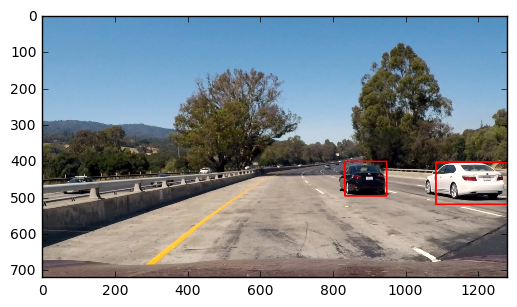

In [61]:
t1 = time.time()

local_maxi = peak_local_max(img_thresh,
                            indices=False,
                            footprint=np.ones((10, 10)),
                            labels=np.copy(img_thresh))

markers = ndi.label(local_maxi)[0]
labels = watershed(-img_thresh, markers, mask=img_thresh)

boxes = np.zeros((len(np.unique(labels))-1, 4), dtype=np.uint32)
for i, cur_label in enumerate(np.unique(labels)):
    if cur_label == 0:
        continue
    filled = np.where(labels == cur_label)
    boxes[i-1] = np.array([[filled[1].min(), filled[0].min(), filled[1].max(), filled[0].max()]])

print('Finished after %f seconds' % (time.time() - t1))
    
img_watershed = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
_ = plt.imshow(img_watershed, cmap='gray')

# Technique 3: Blob + Watershed

Finished after 1.266490 seconds


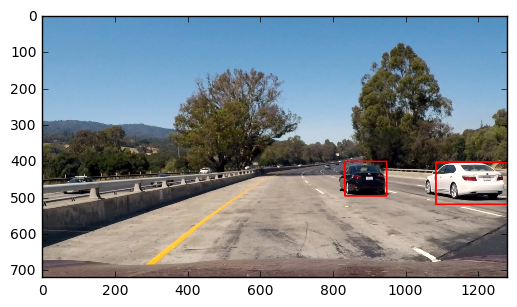

In [62]:
t1 = time.time()

blobs = blob_doh(img_thresh, num_sigma=4, min_sigma=1, max_sigma=255, threshold=.01)
blobs = blobs.astype(np.uint32)
centroids = np.zeros(img.shape, dtype=np.bool)
centroids[blobs[:,0], blobs[:,1]] = True
centroids[centroids==True]

markers = ndi.label(centroids)[0]
labels = watershed(-img_thresh, markers, mask=img_thresh)

boxes = np.zeros((len(np.unique(labels))-1, 4), dtype=np.uint32)
for i, cur_label in enumerate(np.unique(labels)):
    if cur_label == 0:
        continue
    filled = np.where(labels == cur_label)
    boxes[i-1] = np.array([[filled[1].min(), filled[0].min(), filled[1].max(), filled[0].max()]])

print('Finished after %f seconds' % (time.time() - t1))
    
img_blob_water = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
_ = plt.imshow(img_blob_water, cmap='gray')

# Technique 4: Opencv Find Contours

Finished after 0.001656 seconds


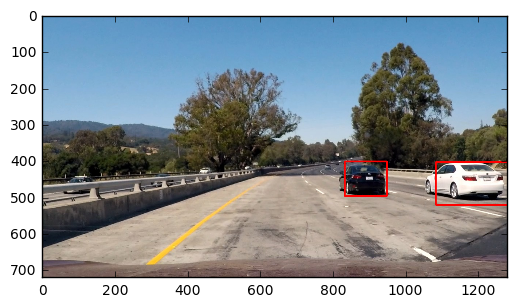

In [63]:
t1 = time.time()

_, contours, _ = cv2.findContours(img_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

boxes = np.zeros((len(contours), 4), dtype=np.uint32)
for i, contour in enumerate(contours):
    rectangle = cv2.boundingRect(contour)

    x,y,w,h = rectangle
    boxes[i] = [x, y, x+w, y+h]

print('Finished after %f seconds' % (time.time() - t1))
    
img_contour = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
_ = plt.imshow(img_contour, cmap='gray')

# Result

All algorithms seem to work well most of the time. However they vary in speed. Opencv find contour is by far the fastest which is why this method will be chosen.

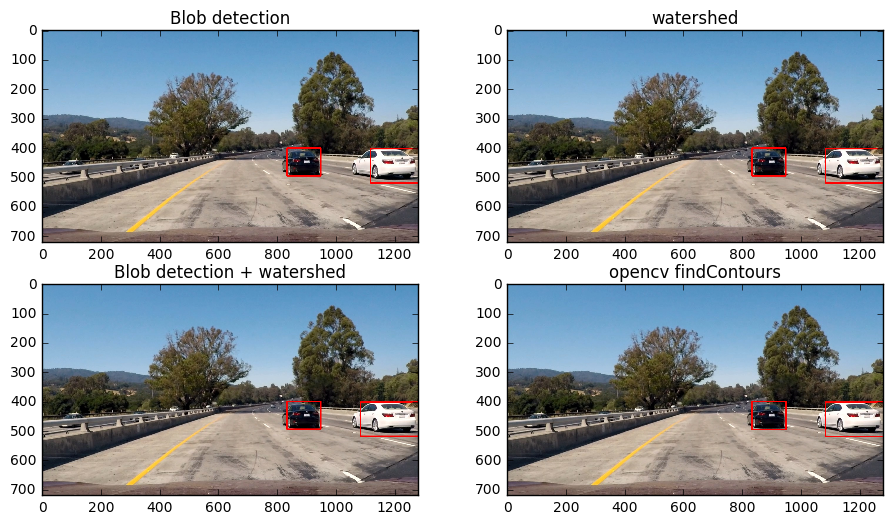

In [71]:
fig, axis = plt.subplots(2,2, figsize=(11,6))
_ = axis[0,0].imshow(img_blob)
_ = axis[0,0].set_title('Blob detection')
_ = axis[0,1].imshow(img_watershed)
_ = axis[0,1].set_title('watershed')
_ = axis[1,0].imshow(img_blob_water)
_ = axis[1,0].set_title('Blob detection + watershed')
_ = axis[1,1].imshow(img_contour)
_ = axis[1,1].set_title('opencv findContours')